In [1]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model, Input, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam # not important as there's no training here.
import tensorflow as tf
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


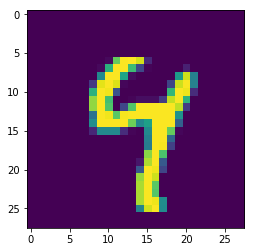

In [3]:
plt.imshow(mnist.train.images[2].reshape(28,28))
plt.show()

In [66]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

input_shape = (img_rows, img_cols, 1)

In [5]:
# x_train = mnist.train.images.reshape(-1, img_rows, img_cols, 1)
# x_valid = mnist.validation.images.reshape(-1, img_rows, img_cols, 1)
# x_test = mnist.test.images.reshape(-1, img_rows, img_cols, 1)

x_train = mnist.train.images
x_valid = mnist.validation.images
x_test = mnist.test.images
print(np.shape(x_train))
print(np.shape(x_valid))
print(np.shape(x_test))

(55000, 784)
(5000, 784)
(10000, 784)


In [6]:
y_train = mnist.train.labels
y_valid = mnist.validation.labels
y_test = mnist.test.labels
print(np.shape(y_train))
print(np.shape(y_valid))
print(np.shape(y_test))

(55000, 10)
(5000, 10)
(10000, 10)


In [83]:
input_layer = Input(shape=(784,))
layer_1 = Dense(784)(input_layer)
output_layer = Dense(num_classes, activation='softmax')(layer_1)
model = Model(input_layer, output_layer)
model.compile(Adam(), 'mse', metrics=['accuracy'])



# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(optimizer= Adam(), loss='mse')



# input_layer = Input(shape=(5,1))
# layer = Dense(8)(input_layer)
# output_layer = Dense(3)(layer)
# model = Model(input_layer, output_layer)
# model.compile(Adam(), 'mse')

In [84]:
model.output

<tf.Tensor 'dense_20/Softmax:0' shape=(?, 10) dtype=float32>

In [85]:
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))

In [86]:
class EvolutionStrategy(object):

    def __init__(self, weights, get_reward_func, population_size=50, sigma=0.1, learning_rate=0.001):
        np.random.seed(0)
        self.weights = weights
        self.get_reward = get_reward_func
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate


    def _get_weights_try(self, w, p):
        weights_try = []
        for index, i in enumerate(p):
            jittered = self.SIGMA*i
            weights_try.append(w[index] + jittered)
        return weights_try


    def get_weights(self):
        return self.weights


    def run(self, iterations, print_step=10):
        for iteration in range(iterations):

            if iteration % print_step == 0:
                print('iter %d. reward: %f' % (iteration, self.get_reward(self.weights)))

            population = []
            rewards = np.zeros(self.POPULATION_SIZE)
            for i in range(self.POPULATION_SIZE):
                x = []
                for w in self.weights:                 
                    x.append(np.random.randn(*w.shape))
                population.append(x)

            for i in range(self.POPULATION_SIZE):
                weights_try = self._get_weights_try(self.weights, population[i])
                rewards[i]  = self.get_reward(weights_try)
            
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)

            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = w + self.LEARNING_RATE/(self.POPULATION_SIZE*self.SIGMA) * np.dot(A.T, rewards).T

In [87]:
def get_reward(weights):
    start_index = np.random.choice(y_train.shape[0]-batch_size,1)[0]-1
    solution = y_train[start_index:start_index+batch_size]
    inp = x_train[start_index:start_index+batch_size]
    
    model.set_weights(weights)
    prediction = model.predict(inp)[0]
    print(prediction.shape, solution.shape)
    print(prediction)

    accuracy = (np.mean(np.equal(np.argmax(prediction), np.argmax(solution,1))))

    reward = -np.sum(np.square(solution - prediction))
    #reward = np.mean(np.equal(np.argmax(prediction), np.argmax(solution)))
    return reward

# def get_reward(weights):
#     solution = np.array([0.5, 0.1, -0.3])
#     inp = np.asarray([[1,2,3,4,5]])
#     inp = np.expand_dims(inp, -1)
    
#     model.set_weights(weights)
#     prediction = model.predict(inp)[0]
#     # here our best reward is zero
#     reward = -np.mean(np.square(solution - prediction))
#     return reward

In [88]:
es = EvolutionStrategy(model.get_weights(), get_reward, population_size=50, sigma=0.1, learning_rate=0.01)
es.run(1000, print_step=10)

(10,) (128, 10)
[ 0.0659879   0.14966287  0.10078061  0.06346384  0.07194627  0.17012163
  0.13442235  0.06233007  0.09860066  0.08268385]
iter 0. reward: -116.665075
(10,) (128, 10)
[  3.34300508e-04   8.44028487e-04   4.18112986e-03   1.45802438e-01
   1.63962692e-02   5.83071589e-01   8.27028975e-02   2.27109231e-05
   1.64287791e-01   2.35680398e-03]
(10,) (128, 10)
[  1.55437796e-04   6.53196722e-02   1.91685413e-05   1.20812252e-01
   3.94856125e-01   1.19745769e-02   1.33684254e-03   1.47679617e-04
   1.55161440e-01   2.50216752e-01]
(10,) (128, 10)
[  3.96028161e-04   9.49970970e-04   7.13945992e-05   5.94174862e-03
   1.55331014e-04   1.47255985e-08   4.65908609e-02   4.34793378e-07
   9.45603967e-01   2.90317228e-04]
(10,) (128, 10)
[ 0.00382885  0.00857371  0.00351855  0.3316164   0.01681288  0.57253563
  0.00228409  0.04021961  0.0033537   0.01725659]
(10,) (128, 10)
[  6.19637743e-02   1.69685925e-03   1.34869455e-03   4.44507413e-03
   4.78325383e-05   1.80606004e-02   5.

(10,) (128, 10)
[  1.57272834e-02   1.39080745e-03   1.75766185e-01   7.18285799e-01
   4.18737307e-02   1.40237631e-02   3.92265123e-04   1.67003620e-07
   6.81148435e-04   3.18587944e-02]
(10,) (128, 10)
[  7.32446611e-02   1.51287233e-02   5.73944785e-02   1.28621543e-02
   7.52406418e-01   1.68106966e-02   4.86561585e-05   4.26611910e-03
   1.43741220e-02   5.34638502e-02]
(10,) (128, 10)
[  9.27551687e-02   6.63879141e-02   9.77356322e-05   6.03244524e-04
   1.31302431e-01   6.31348372e-01   9.63639177e-05   7.96657614e-03
   4.62842211e-02   2.31579915e-02]
(10,) (128, 10)
[  3.18487346e-01   6.60587626e-04   2.59117718e-04   2.05062106e-02
   2.21954554e-01   1.07556678e-01   2.64477294e-05   9.94636491e-03
   3.18839282e-01   1.76339911e-03]
(10,) (128, 10)
[  3.94538714e-04   7.36478157e-03   2.34678853e-04   1.40282046e-03
   2.14999467e-01   7.02152491e-01   2.67725810e-03   3.30029125e-03
   3.72483842e-02   3.02252918e-02]
(10,) (128, 10)
[  1.47490227e-03   1.44554833e-02

KeyboardInterrupt: 

In [70]:
y_train[1:1+batch_size]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])